# UCI Heart Disease Dataset: Initial Exploration

## Context
The UCI Heart Disease database contains data from four locations: Cleveland, Hungary, Switzerland, and the VA Long Beach. It contains 76 attributes, though most published experiments use a subset of 14 features. The target variable represents the presence and severity of heart disease on a 0-4 scale, where 0 indicates no disease and 1-4 represent increasing severity levels.

Creators:

Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

## Objective
This notebook performs an initial exploration of the complete UCI Heart Disease dataset to understand its structure, quality, and characteristics before proceeding with detailed analysis and modeling. This notebook explores the combined dataset, not the data from the individual locations.

## Research Questions
1. What variables are available in the dataset and what do they represent?
2. What is the distribution of heart disease severity across all samples?
3. What is the extent and pattern of missing data?
4. Are there any immediate data quality issues that need to be addressed?
5. Do missing data patterns suggest the need for population-specific analysis?

## Notebook Outline
1. Data Loading & Basic Overview
2. Variable Description & Data Dictionary
3. Target Variable Analysis
4. Missing Data Analysis
5. Initial Observations & Next Steps

## Important Note

Most of the functions that I'll be using in this project are defined in the `utils` folder. I'll make sure to mention when a function defined in this folder is used.  

In [23]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings

# Statistical and clustering utilities for missingness analysis
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram

# Setting up general plot styles
from utils.data_visualizations import setup_plot_style 
setup_plot_style()

# Display dataframe numerical values up to 2 decimal points
pd.options.display.float_format = "{:,.2f}".format



---
## 1) What variables are available in the dataset and what do they represent?

To do this we start by loading the combined dataset which is defined in the `load_datasets.py` file. To keep things modular (avoiding code repititions), all notebooks will use the dataframes defined in that file.

In [24]:
# Loading the dataset
from load_datasets import df_combined as df

# Work on a copy to avoid accidental edits to the shared object
df = df.copy()

df.head()


,Age,Sex,Chest Pain,Rest BP,Chol,FBS,Rest ECG,Max HR,Ex Angina,Oldpeak,Slope,Ca,Thal,CVD Class,Dataset
0,67.00,1.00,4.00,160.00,286.00,0.00,2.00,108.00,1.00,1.50,2.00,3.0,3.0,2,Cleveland
1,67.00,1.00,4.00,120.00,229.00,0.00,2.00,129.00,1.00,2.60,2.00,2.0,7.0,1,Cleveland
2,37.00,1.00,3.00,130.00,250.00,0.00,0.00,187.00,0.00,3.50,3.00,0.0,3.0,0,Cleveland
3,41.00,0.00,2.00,130.00,204.00,0.00,2.00,172.00,0.00,1.40,1.00,0.0,3.0,0,Cleveland
4,56.00,1.00,2.00,120.00,236.00,0.00,0.00,178.00,0.00,0.80,1.00,0.0,3.0,0,Cleveland


We can now look at basic statistics from the dataset

In [25]:
# Basic structure and data types
print(f"=== Dataset Dimensions ===")
print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")

# Data types
print("=== Data Types ===")
print(df.dtypes.value_counts())

# Basic info
print("=== Dataset Info ===")
df.info()


=== Dataset Dimensions ===
Rows: 916, Columns: 15
=== Data Types ===
object     11
float64     3
int64       1
Name: count, dtype: int64
=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         916 non-null    float64
 1   Sex         916 non-null    float64
 2   Chest Pain  916 non-null    float64
 3   Rest BP     857 non-null    object 
 4   Chol        886 non-null    object 
 5   FBS         827 non-null    object 
 6   Rest ECG    914 non-null    object 
 7   Max HR      861 non-null    object 
 8   Ex Angina   861 non-null    object 
 9   Oldpeak     854 non-null    object 
 10  Slope       608 non-null    object 
 11  Ca          308 non-null    object 
 12  Thal        433 non-null    object 
 13  CVD Class   916 non-null    int64  
 14  Dataset     916 non-null    object 
dtypes: float64(3), int64(1), object(11)

In [26]:
# Summary statistics across numeric and categorical columns
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,916.00,NaN,NaN,NaN,53.54,9.37,29.00,47.00,54.00,60.00,77.00
Sex,916.00,NaN,NaN,NaN,0.79,0.41,0.00,1.00,1.00,1.00,1.00
Chest Pain,916.00,NaN,NaN,NaN,3.26,0.93,1.00,3.00,4.00,4.00,4.00
Rest BP,857,102,120,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chol,886.00,334.00,0.00,122.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FBS,827,4,0,432,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rest ECG,914,6,0,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max HR,861,197,150,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ex Angina,861,4,0,322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oldpeak,854.00,81.00,0.00,287.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column Descriptions:

| Var. Name | Role | Type | Units | Notes |
|------|------|------|-------|-------|
| Age | Predictor | Integer | years | Age of the patient |
| Sex | Predictor | Categorical | N/A | 1 = male, 0 = female |
| Chest Pain | Predictor | Categorical | N/A | 1 = typical angina, 2 = atypical angina, 3 = non-anginal, 4 = asymptomatic |
| Rest BP | Predictor | Integer | mmHg | Resting blood pressure (on admission) |
| Chol | Predictor | Integer | mg/dl | Serum cholesterol |
| FBS | Predictor | Binary | N/A | Fasting blood sugar > 120 mg/dl (1 = true, 0 = false) |
| Rest ECG | Predictor | Categorical | N/A | 0 = normal, 1 = ST-T abnormality, 2 = LV hypertrophy |
| Max HR | Predictor | Integer | bpm | Maximum heart rate achieved |
| Ex Angina | Predictor | Binary | N/A | Exercise-induced angina (1 = yes, 0 = no) |
| Oldpeak | Predictor | Float | N/A | ST depression induced by exercise relative to rest |
| Slope | Predictor | Categorical | N/A | 1 = upsloping, 2 = flat, 3 = downsloping |
| Ca | Predictor | Integer | count | Number of major vessels colored by fluoroscopy (0-3) |
| Thal | Predictor | Categorical | N/A | 3 = normal, 6 = fixed defect, 7 = reversible defect |
| CVD Class | Target | Ordinal | N/A | 0 = no disease, 1-4 = increasing severity |
| Dataset | Identifier | Categorical | N/A | Data source site (Cleveland, Hungary, Switzerland, VA Long Beach) |

Assumption: the above encodings follow the standard UCI Heart Disease documentation. We will verify with data ranges and adjust if needed.


---
## 2) What is the distribution of heart disease severity across all samples?

It is important for us to understand the distribution of the heart disease (CVD) class to handle potential skewness and class imbalances that could cause issues later on. To be more precise, this will help determine what techniques to use when building models, and will help test our assumptions about the data.

In [27]:
# Ensure CVD Class is numeric for consistent ordering
cvd_numeric = pd.to_numeric(df['CVD Class'], errors='coerce')

# Frequency and percentage distribution
cvd_counts = cvd_numeric.value_counts(dropna=False).sort_index()
cvd_percent = (cvd_counts / cvd_counts.sum() * 100).round(2)

cvd_distribution = pd.DataFrame({
    'Count': cvd_counts,
    'Percent': cvd_percent
})
cvd_distribution


,Count,Percent
CVD Class,,
0,409,44.65
1,264,28.82
2,108,11.79
3,107,11.68
4,28,3.06


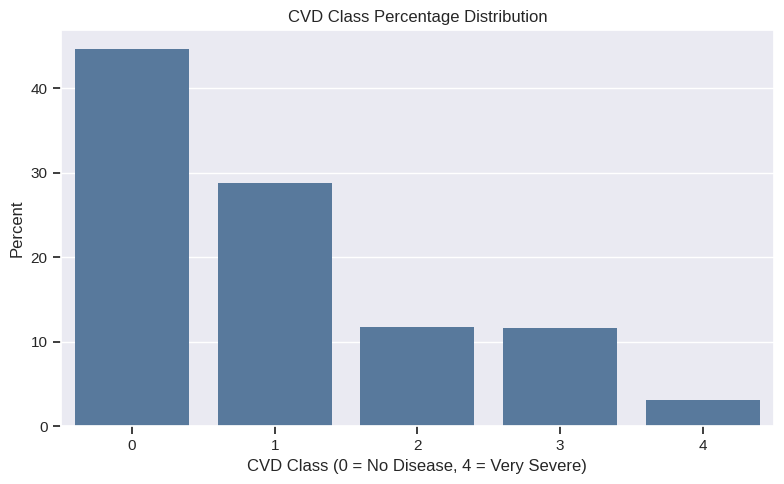

In [28]:
# Plot percentage distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=cvd_distribution.index, y=cvd_distribution['Percent'], color='#4C78A8')
plt.title('CVD Class Percentage Distribution')
plt.xlabel('CVD Class (0 = No Disease, 4 = Very Severe)')
plt.ylabel('Percent')
plt.tight_layout()
plt.show()


---
## 3) What is the extent and pattern of missing data?

This question is extremely important to understand, especially given the nature of our data. Since the combined dataset comes from four separate locations, we want to analyze missingness patterns to see if there are fundamental differences between these populations. 

For example, if a specific feature is shown to be be missing 

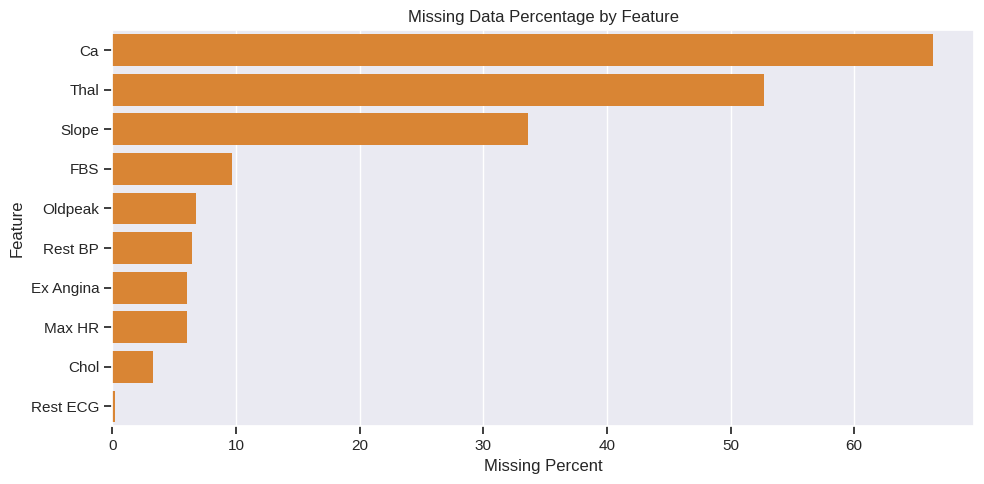

In [29]:
from utils.data_quality import calculate_missingness_summary, get_complete_case_percentage, create_data_quality_report

# Missingness summary by feature
missing_data = calculate_missingness_summary(dataframe=df)
missing_data.round(2)


In [ ]:
# Visualize missingness percentage per feature
plt.figure(figsize=(10, 5))
sns.barplot(data=missing_data, y='Feature', x='Missing_Percent', color='#F58518')
plt.title('Missing Data Percentage by Feature')
plt.xlabel('Missing Percent')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Total missing data percentage
We can now observe what percentage of values are missing in total, and how complete the dataset is at the row level.


In [30]:
# Overall completeness
total_complete_cases_percent = get_complete_case_percentage(df)

print(f"Incomplete cases (missing at least one value): {100 - total_complete_cases_percent:.2f}%")
print(f"Complete cases (no missing values): {total_complete_cases_percent:.2f}%")


Incomplete cases (missing at least one value): 67.47%
Complete cases (no missing values): 32.53%


Here we look at missingness patterns and co-occurrence. This helps us decide whether missingness is random or clustered by feature (or by dataset).


In [31]:
# Identify features with missing values
missing_cols = missing_data['Feature'].tolist()

# Create binary missingness indicators
missing_matrix = df[missing_cols].isnull().astype(int)
missing_matrix.columns = [f"{col}_missing" for col in missing_cols]

# Calculate co-occurrence (correlation of missingness)
cooccurrence = missing_matrix.corr()
cooccurrence.head(3).round(2)


,Ca_missing,Thal_missing,Slope_missing,FBS_missing,Oldpeak_missing,Rest BP_missing,Ex Angina_missing,Max HR_missing,Chol_missing,Rest ECG_missing
Ca_missing,1.00,0.71,0.49,0.19,0.19,0.19,0.18,0.18,0.12,0.03
Thal_missing,0.71,1.00,0.45,0.10,0.19,0.21,0.22,0.22,0.15,0.04
Slope_missing,0.49,0.45,1.00,-0.07,0.38,0.34,0.35,0.35,0.15,0.02


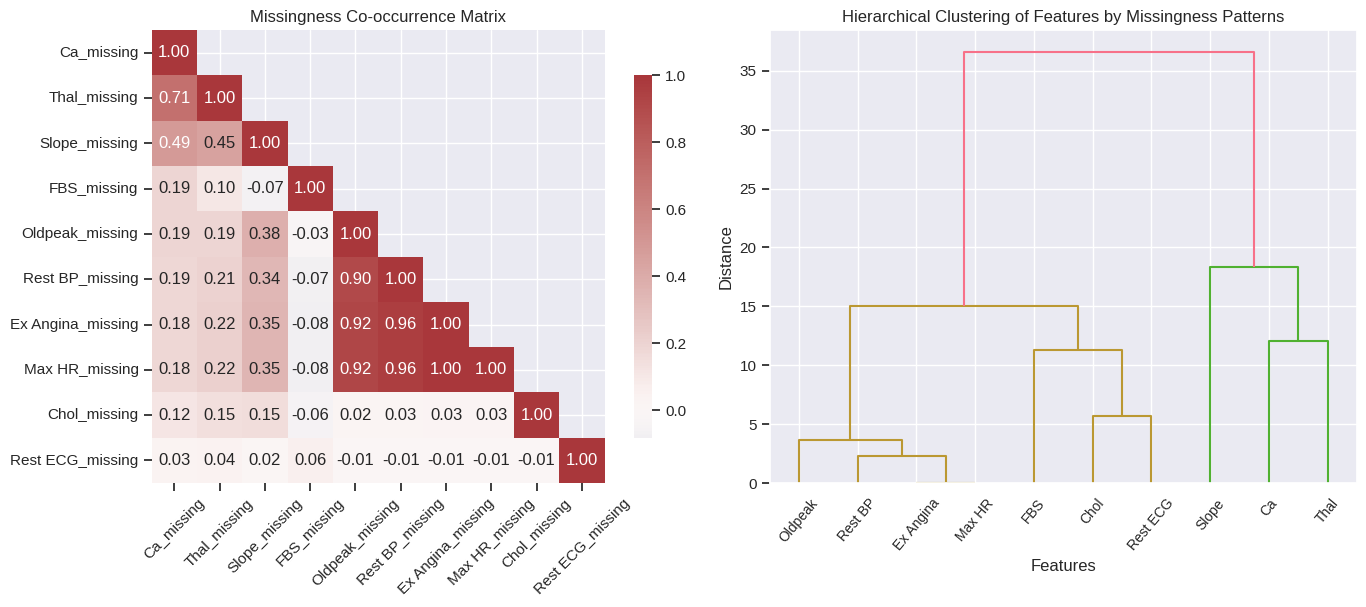

In [41]:
# Plotting the correlation of missing features
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
mask = np.triu(np.ones_like(cooccurrence, dtype=bool), k=1)
sns.heatmap(cooccurrence, annot=True, fmt='.2f', cmap='vlag',
            center=0, square=True, mask=mask, cbar_kws={"shrink": 0.8}, ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Missingness Co-occurrence Matrix')

# Cluster features by missingness patterns
linkage_matrix = linkage(missing_matrix.T, method='ward')

dendrogram(linkage_matrix, labels=[col.replace('_missing', '') 
                                    for col in missing_matrix.columns],
           leaf_rotation=50, leaf_font_size=10, ax=ax[1])
ax[1].set_title('Hierarchical Clustering of Features by Missingness Patterns')
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Distance')

plt.tight_layout()
plt.show()


Looking at the results, some missingness patterns are clearly clustered rather than random. This suggests that data collection differences (such as clinical protocols by site) may be driving the gaps.


---
## 4) Are there any immediate data quality issues that need to be addressed?

In [33]:
# Data quality report (duplicates, completeness, missing cells)
quality_report = create_data_quality_report(df, dataset_name='Combined')
pd.Series(quality_report)

# Assumptions for validity checks (based on standard UCI encodings)
categorical_domains = {
    'Sex': {0, 1},
    'Chest Pain': {1, 2, 3, 4},
    'FBS': {0, 1},
    'Rest ECG': {0, 1, 2},
    'Ex Angina': {0, 1},
    'Slope': {1, 2, 3},
    'Ca': {0, 1, 2, 3},
    'Thal': {3, 6, 7},
    'CVD Class': {0, 1, 2, 3, 4}
}

range_checks = {
    'Age': (0, 120),
    'Rest BP': (80, 250),
    'Chol': (50, 700),
    'Max HR': (60, 220),
    'Oldpeak': (0, 10)
}

# Coerce numeric for checks without modifying the original df
df_numeric = df.copy()
for col in set(list(categorical_domains.keys()) + list(range_checks.keys())):
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

# Count non-numeric entries
non_numeric_counts = {}
for col in set(list(categorical_domains.keys()) + list(range_checks.keys())):
    non_numeric_counts[col] = (df[col].notnull() & df_numeric[col].isnull()).sum()

# Count out-of-domain values for categorical variables
invalid_domain_counts = {}
for col, allowed in categorical_domains.items():
    invalid_domain_counts[col] = (~df_numeric[col].isin(allowed) & df_numeric[col].notnull()).sum()

# Count out-of-range values for numeric variables
out_of_range_counts = {}
for col, (min_val, max_val) in range_checks.items():
    out_of_range_counts[col] = ((df_numeric[col] < min_val) | (df_numeric[col] > max_val)).sum()

quality_issues = pd.DataFrame({
    'Non_Numeric_Count': pd.Series(non_numeric_counts),
    'Invalid_Domain_Count': pd.Series(invalid_domain_counts),
    'Out_Of_Range_Count': pd.Series(out_of_range_counts)
}).fillna(0).astype(int)

quality_issues


,Non_Numeric_Count,Invalid_Domain_Count,Out_Of_Range_Count
Age,0,0,0
CVD Class,0,0,0
Ca,0,0,0
Chest Pain,0,0,0
Chol,0,0,171
Ex Angina,0,0,0
FBS,0,0,0
Max HR,0,0,0
Oldpeak,0,0,12
Rest BP,0,0,1


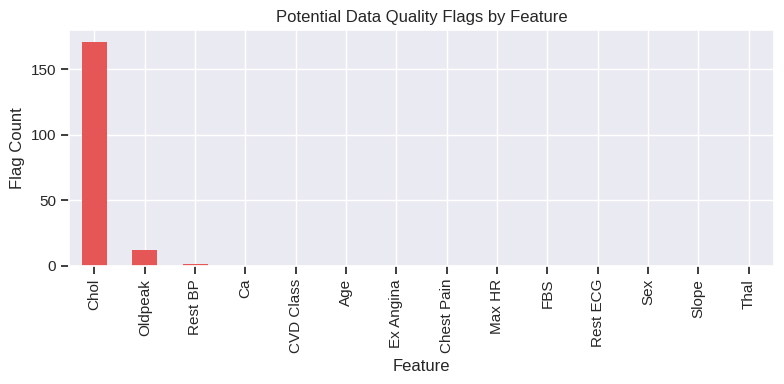

In [34]:
# Visualize any potential data quality flags
plt.figure(figsize=(8, 4))
quality_issues.sum(axis=1).sort_values(ascending=False).plot(kind='bar', color='#E45756')
plt.title('Potential Data Quality Flags by Feature')
plt.xlabel('Feature')
plt.ylabel('Flag Count')
plt.tight_layout()
plt.show()

## 5) Do missing data patterns suggest the need for population-specific analysis?

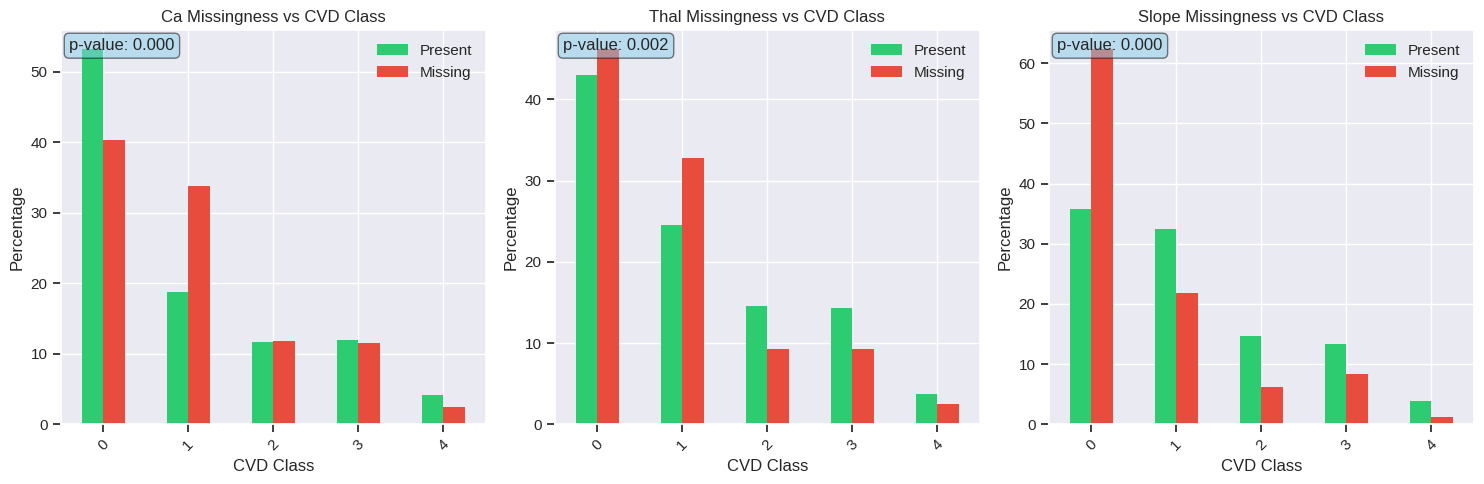

In [35]:
# Investigate whether missingness relates to target label
high_miss_features = ['Ca', 'Thal', 'Slope']
target_col = 'CVD Class'

# Create visualization
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for idx, feature in enumerate(high_miss_features):
    if idx < len(high_miss_features):
        is_missing = df[feature].isnull()
        cross_tab = pd.crosstab(df[target_col], is_missing, normalize='columns') * 100
        
        cross_tab.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
        axes[idx].set_title(f'{feature} Missingness vs {target_col}')
        axes[idx].set_xlabel(target_col)
        axes[idx].set_ylabel('Percentage')
        axes[idx].legend(['Present', 'Missing'], loc='best')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
        
        # Chi-square test
        contingency = pd.crosstab(df[target_col], is_missing)
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        axes[idx].text(0.02, 0.98, f'p-value: {p_value:.3f}', 
                        transform=axes[idx].transAxes, 
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='skyblue', alpha=0.5))

plt.tight_layout()
plt.show()


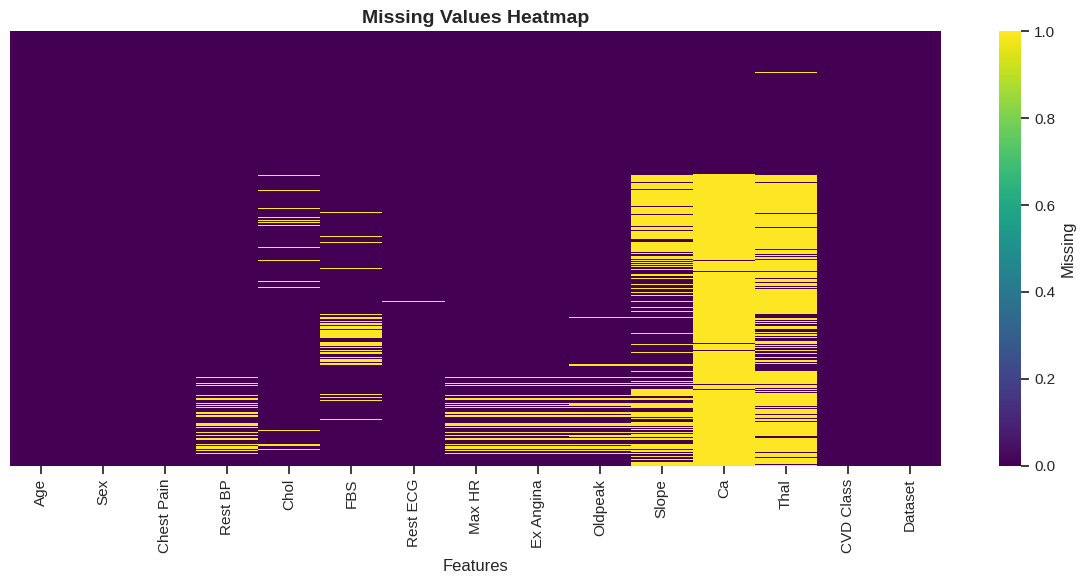

In [36]:
from utils.data_visualizations import plot_missingness_heatmap 

plot_missingness_heatmap(dataframe=df)

The results above suggest that missingness is not completely random. Some missingness appears associated with both the target label and the dataset source, which supports population-specific analysis or at least stratified validation by site.
